In [1]:
import numpy as np , pandas as pd
import torch
import torch.nn as nn

import torch
from torch.utils.data import Dataset, DataLoader

import einops
import pickle
from tqdm import tqdm

import configparser


In [2]:
# load the encoded variables
file_path = 'encoded_vars/token_vars_income.pkl'

with open(file_path, 'rb') as file:
    loaded_variable = pickle.load(file)
    
print("Loaded variable :",loaded_variable.keys())
df = loaded_variable["df"]
col_code = loaded_variable["col_code"]
tokenizer = loaded_variable["tokenizer"]

Loaded variable : dict_keys(['col_code', 'df', 'tokenizer'])


In [3]:
df # make sure that its in the same order as encoding

In [4]:
train_set = torch.load("encoded_vars/train_set.pt")
valid_set = torch.load("encoded_vars/valid_set.pt")

{'vocab_length': 21979,
 'val_split': 20,
 'test_split': 10,
 'epochs': 2,
 'n_embed': 992,
 'n_heads': 31,
 'context_window': 38,
 'transformer_blocks': 2,
 'batch_size': 32,
 'random_seed': 123}

In [5]:
len(train_set),len(valid_set)

In [ ]:
config = configparser.ConfigParser()
config.read('settings.ini')

config= {key: int(value) for key, value in config['INCOME_DATASET'].items()}
config

In [7]:
class TokenDataset(Dataset):
    def __init__(self, data_set, context_window):
        self.dataset = data_set
        self.context_window = context_window
        self.X, self.y = self.compile_dataset()

    def compile_dataset(self):
        X = []
        y = []
        for row in tqdm(self.dataset):
            row_tensor = torch.tensor(row[1:], dtype=torch.long)
            context = torch.zeros(self.context_window, dtype=torch.long)

            for value in row_tensor:
                X.append(context.clone().unsqueeze(0))
                y.append(torch.tensor([value]))
                context = torch.cat((context[1:], torch.tensor([value])))

        X = torch.cat(X, dim=0)
        y = torch.cat(y, dim=0)
        return X, y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


100%|██████████| 8792/8792 [00:00<00:00, 11757.75it/s]


In [8]:
train_set[:1]

In [9]:
trainDataset = TokenDataset(train_set,config["context_window"])
train_loader = DataLoader(trainDataset, batch_size=32, shuffle=True)

In [10]:
validDataset = TokenDataset(valid_set,config["context_window"])
valid_loader = DataLoader(validDataset, batch_size=32, shuffle=True)

In [10]:
for Xb ,yb in train_loader:
    print(Xb.shape ,yb.shape)
    break

In [11]:
Xb

In [12]:
class SingleHead(nn.Module):
    """
    Implements a single head of attention (unmasked)
    """

    def __init__(self,R,head_size,manual_seed=123):
        super().__init__()
        # single head
        self.head_size = head_size
        self.scale = 1/ torch.sqrt(torch.tensor(self.head_size))
        self.R = torch.tensor(R)
        self.Q = nn.Parameter( torch.randn(self.R,head_size))
        self.K = nn.Parameter( torch.randn(self.R,head_size))
        self.V = nn.Parameter( torch.randn(self.R,head_size))

    def forward(self,x):
        q = x @ self.Q # (B,T,R) * (R,h) => (B,T,R) x (B,R,h) => (B,T,h) 
        k = x @ self.K
        v = x @ self.V

        comm = q @ einops.rearrange(k,"B T h -> B h T") # (B,T,h) @ (B,h,T) => B,T,T @ each tokens interaction with each token would be T,T
        att1 = nn.functional.softmax(comm * self.scale,dim=2) # along tokens head
        attention = att1 @ v # B,T,T @ B,T,h => B,T,h
        return attention

AdamW (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0.01
)

In [14]:
class Multihead(nn.Module):
    def __init__(self,R,n_heads,seed=123):
        self.R = R
        assert R % n_heads == 0 , "n_heads is not divisible by R"
        self.head_size = self.R // n_heads
        self.n_heads = n_heads

        super().__init__()
        self.multiheads = nn.ModuleList(
            [SingleHead(self.R,self.head_size)  for _ in range(self.n_heads)]
        )

    def forward(self,x):
        return torch.cat([head(x) for head in self.multiheads],dim=2)

  0%|          | 0/713 [00:00<?, ?it/s]/var/folders/f0/_f_gy0t91jqchv14f0hcl_gh0000gn/T/ipykernel_91199/468654311.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(inputs), torch.tensor(targets)
100%|██████████| 713/713 [05:24<00:00,  2.20it/s]


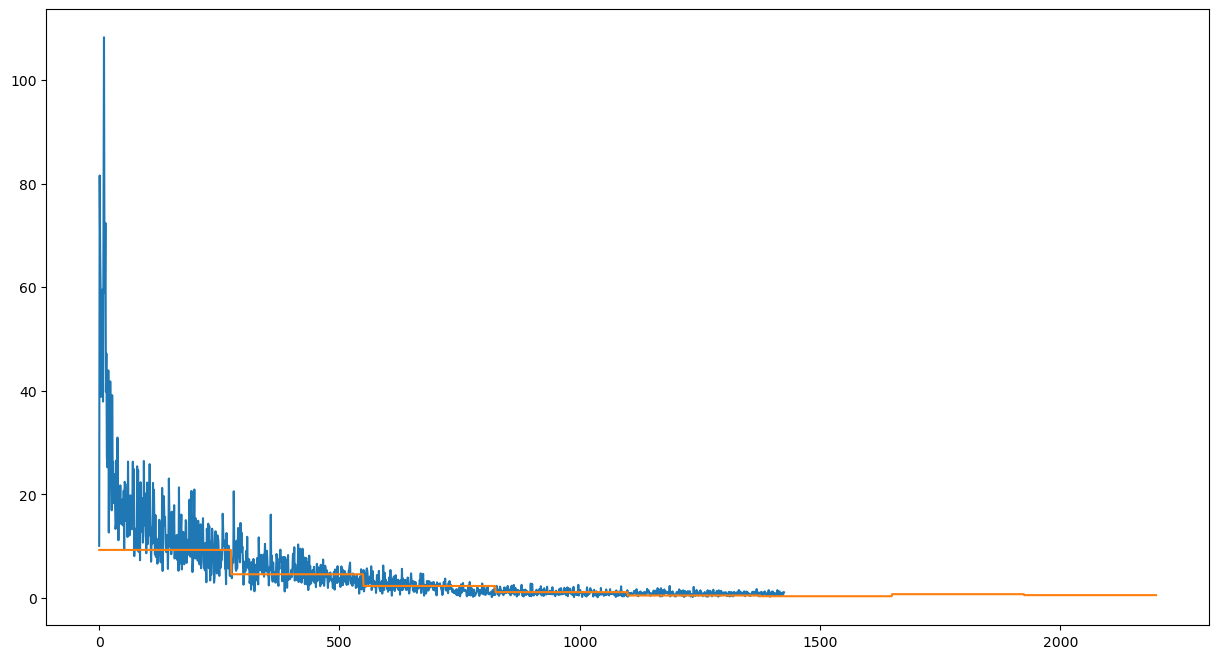

In [17]:
class IncomeTransformer(nn.Module):
    def __init__(self,config):
        super().__init__()
        self.context_window = config["context_window"]
        self.n_embed = config["n_embed"]
        self.n_heads = config["n_heads"]
        self.n_vocab = config["vocab_length"]
        self.transformer_blocks = config["transformer_blocks"]

        #==== Token (C) and positional Embedding (pe)
        self.C = nn.Embedding(self.n_vocab,self.n_embed) # token embedding
        self.pe = nn.Parameter(torch.randn(1,self.n_embed)) # position embedding

        #===== Transformer Blocks
        self.multi_heads , self.layer_norm = [],[]
        for i in range(self.transformer_blocks):
            self.multi_heads.append( Multihead(R=self.n_embed, n_heads=self.n_heads))
            self.layer_norm.append(nn.LayerNorm(self.n_embed)) #at the end of the transformer block

        #==== MLP Head
        self.mlp_head0 = nn.Linear(self.context_window * self.n_embed , self.n_embed)
        self.mlp_head1 = nn.Linear(self.n_embed,self.n_vocab + 1) # logits



    def forward(self,x):
        emb = self.C(x) # token emb
        emb += self.pe # add pos emb

        # write a loop later : 2 blocks
        attn0 = self.multi_heads[0](emb)
        # skip connection
        skip0 = torch.nn.functional.leaky_relu(attn0) + emb
        normed0 = self.layer_norm[0](skip0)# layer norm and skip connection
        
        attn1 = self.multi_heads[1](normed0)
        skip1 = torch.nn.functional.leaky_relu(attn1) + normed0
        normed1 = self.layer_norm[1](skip1)

        # flatten
        normed = einops.rearrange(normed1,"b t e -> b (t e)")
        x = self.mlp_head0(normed)
        logits = self.mlp_head1(x) # logits

        return logits

    def calculate_loss(self,x,y):
        logits = self(x)
        return logits , nn.functional.cross_entropy(logits,y)

    def generate(self,seed = None,verbose=False):
        seed = [0] * self.context_window if seed is None else seed
        generation = list()
        i = 0
        while True:
            if verbose:
                print(seed)
            logits = self(torch.tensor(seed).view(1,-1))
            probs = nn.functional.softmax(logits,dim=1)
            prediction = torch.multinomial(probs,num_samples=1)
            generation.append(prediction.item())
            seed = seed[1:] + [prediction.item()]
            if verbose:
                print(prediction.item())
            i = i+1
        return generation



model = IncomeTransformer(config)

In [18]:
track_loss = list()
valid_loss = list()


9.997842731017274

In [23]:
optimizer = torch.optim.AdamW(model.parameters(),lr=1e-3)
optimizer

(1.082310438156128, tensor(0.5323))

In [21]:
for epoch in range(config["epochs"]):
    i = 0
    for Xb,yb in tqdm(train_loader):

        # forward pass
        _,loss = model.calculate_loss(Xb,yb)
        i+=1

        # flush the gradients 
        optimizer.zero_grad(set_to_none=True)

        # backprop
        loss.backward()

        # learning step
        optimizer.step()

        # for plotting
        track_loss.append(loss.item())
        
        if i % 200 == 0:
            # or set model.eval()
            with torch.no_grad(): # this is more explicit though:
                for X_eval , y_eval in valid_loader:
                    # forward pass
                    _,val_loss = model.calculate_loss(Xb,yb)
                    valid_loss.append(val_loss)
                    

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15,8))
plt.plot(track_loss,label="training loss")
plt.plot(valid_loss,label="valid loss")
plt.show()

In [ ]:
# expected_loss
-1 * np.log(1/config["vocab_length"])

In [ ]:
# our loss
track_loss[-1],valid_loss[-1]

In [ ]:
# Save the model weights and structure
torch.save(model.state_dict(), 'model_weights.pth')
torch.save(model, 'model_complete.pth')